In [47]:
%matplotlib inline 
import matplotlib.pylab as plt 
from matplotlib import lines
import numpy as np 
import seaborn as sns
sns.set_style('ticks')
default_colors = sns.color_palette()

import pandas as pd 

import CRISPR_Kinetic_model as Cas9
reload(Cas9);

import Bio
from Bio.pairwise2 import format_alignment
import copy

import sys 
sys.path.append('../code_Boyle/')
import plotting_Boyle as plt_B
reload(plt_B);

import analysis_SA_fits as SAfits
reload(SAfits);

## Ilya's data Cas9 target E

In [48]:
filename = 'ECas9_cleavage_rate_and_y0.txt'
Path = '../data_nucleaseq_Finkelsteinlab/targetE/'
Cas='Cas9'
data = pd.read_table(Path+filename, usecols=['target', 'cleavage_rate', 'cleavage_rate_5th_pctl', 'cleavage_rate_95th_pctl'])
data.rename(columns={'target':'Sequence'}, inplace=True)
on_target = 'TTTAGACGCATAAAGATGAGACGCTGG' 

In [49]:
def separate_PAM(S, Cas='Cas9'):
    
    if Cas == 'Cas9':
        PAM_len =3
        PAM = S[-PAM_len:]
        s = S[0:-PAM_len]
        s = s[::-1]
        s = s[0:-4]
        canonical = False
        if PAM[1:]=='GG':
            canonical = True
    if Cas == 'Cas12a':
        PAM_len = 4
        PAM = S[:PAM_len]
        s = S[PAM_len:]
        s = s[0:-3]
        canonical = False
        if (PAM[:3]=='TTT')&(PAM[3]!='T'):
            canonical = True
    return PAM, s, canonical

def find_length_diff(S, on_target, Cas='Cas9'):
    
    _, s, _ = separate_PAM(S, Cas)
    _, t, _ = separate_PAM(on_target, Cas='Cas9')
    return len(s)-len(t)

def Allign(S, on_target, Cas):
    
    _, s, _ = separate_PAM(S, Cas)
    _, t, _ = separate_PAM(on_target, Cas)
    A = Bio.pairwise2.align.globalxx(t, s)
    if len(s)==len(t):
        MM_num = np.sum(np.array(list(t))==np.array(list(s)))
        a = (t,s,MM_num,0,len(t))
        if a not in A:
            A.append(a)
    
    return A

In [50]:
data['On Target'] = data['Sequence'] == on_target
data['PAM'] = data['Sequence'].apply(lambda S: separate_PAM(S, Cas)[0])
data['Canonical'] = data['Sequence'].apply(lambda S: separate_PAM(S, Cas)[2])
data['Length difference'] = data['Sequence'].apply(lambda S: find_length_diff(S, on_target, Cas))
data['Alignment_raw'] = data['Sequence'].apply(lambda S: Allign(S, on_target, Cas))


In [51]:
def Clean_allignment(x):
    A = copy.deepcopy(x['Alignment_raw'])
    Length_diff = x['Length difference']

    if Length_diff == 0:
        function_to_filter = lambda a: not(('-' in a[0]) or ('-' in a[1]))
        A = filter(function_to_filter, A)
        return A
    
    if Length_diff > 0:
        function_to_filter = lambda a: not(('-' not in a[0]) or ('-' in a[1]))
        A = filter(function_to_filter, A)
        id_for_sort = lambda a: '|'.join(map(lambda x: str(x), list(np.arange(1,len(a[0])+1)[np.array(list(a[0])) != np.array(list(a[1]))])))
        if len(A)>1:        
            A.sort(key=id_for_sort, reverse=True)
            del A[1:]
        return(A)
    
    if Length_diff < 0:
        function_to_filter = lambda a: not(('-' in a[0]) or ('-' not in a[1]))
        A = filter(function_to_filter, A)
        id_for_sort = lambda a: '|'.join(map(lambda x: str(x), list(np.arange(1,len(a[0])+1)[np.array(list(a[0])) != np.array(list(a[1]))])))
        if len(A)>1:        
            A.sort(key=id_for_sort, reverse=True)
            del A[1:]
        return(A)



In [52]:
data['Alignment_selected'] = data.apply(Clean_allignment, axis=1)
data['Alignment'] = data['Alignment_selected'].apply(lambda A: format_alignment(*A[0]).split('S')[0] if len(A) > 0 else '')
data['Alignment (All)'] = data['Alignment_raw'].apply(lambda A: ('\n').join(map(lambda a: format_alignment(*a).split('S')[0], A)) if len(A)>0 else '')

In [53]:
def Make_Mutation_ID(x):
    
    if len(x['Alignment_selected']) == 0:
        return ''
    
    Length_diff = x['Length difference']
    a = x['Alignment_selected'][0]

    if Length_diff > 0:
        ta = np.array(list(a[0]))
        sa = np.array(list(a[1]))
        All_positions = np.arange(1,len(sa)+1)
        Mut_positions_on_s = All_positions[ta!=sa]
        Mut_Seqs = sa[[ta!=sa]]
        Mut_types = np.array(['i']*len(Mut_Seqs))
        Mut_Seqs_on_t = ta[[ta!=sa]]
        Mut_types[Mut_Seqs_on_t!='-'] = 'r'
        offset = np.zeros(len(Mut_types), dtype=int)
        for n in range(len(offset)):
            offset[n] = np.sum(Mut_types[0:n]=='i')
        # For insertion it gives the position of a base on the target before which there is an insertion.
        Mut_positions = Mut_positions_on_s - offset 
        ID_list = []
        for Mut_type, Mut_pos, Mut_Seq in zip(Mut_types, Mut_positions, Mut_Seqs):
            ID_list.append(':'.join([Mut_type, str(Mut_pos), Mut_Seq]))
        ID_list = filter(lambda x: 'i:21' not in x[:-2], ID_list) # Insertion after position 20 does not count.
        ID = '|'.join(ID_list)

    if Length_diff < 0:
        ta = np.array(list(a[0]))
        sa = np.array(list(a[1]))
        All_positions = np.arange(1,len(ta)+1)
        Mut_positions = All_positions[ta!=sa]
        Mut_Seqs = ta[[ta!=sa]]
        Mut_types = np.array(['d']*len(Mut_Seqs))
        Mut_Seqs_on_s = sa[[ta!=sa]]
        Mut_types[Mut_Seqs_on_s!='-'] = 'r'
        ID_list = []
        for Mut_type, Mut_pos, Mut_Seq in zip(Mut_types, Mut_positions, Mut_Seqs):
            ID_list.append(':'.join([Mut_type, str(Mut_pos), Mut_Seq]))
        ID = '|'.join(ID_list)

    if Length_diff == 0:
        ta = np.array(list(a[0]))
        sa = np.array(list(a[1]))
        All_positions = np.arange(1,len(ta)+1)
        Mut_positions = All_positions[ta!=sa]
        Mut_Seqs = sa[[ta!=sa]]
        Mut_types = np.array(['r']*len(Mut_Seqs))
        ID_list = []
        for Mut_type, Mut_pos, Mut_Seq in zip(Mut_types, Mut_positions, Mut_Seqs):
            ID_list.append(':'.join([Mut_type, str(Mut_pos), Mut_Seq]))
        ID = '|'.join(ID_list)
    
    return ID

In [54]:
data['Mutation ID'] = data.apply(Make_Mutation_ID, axis=1)
data['Mutation Type'] = data['Mutation ID'].apply(lambda x: '|'.join(map(lambda y: y[0], x.split('|'))) if x!='' else '')
data['Mutation Count'] = data['Mutation Type'].apply(lambda x: len(x.split('|')) if x!='' else np.NaN)

In [55]:
data = data[['Sequence', 'On Target', 'PAM', 'Canonical', 'Length difference', 'Alignment', 'Alignment (All)', 
             'Mutation ID', 'Mutation Type', 'Mutation Count', 'cleavage_rate', 'cleavage_rate_5th_pctl', 'cleavage_rate_95th_pctl']]

In [56]:
data_1mm = data[data['Canonical']&(data['Mutation Count']==1)&(data['Length difference']==0)&(data['Mutation Type']=='r')]
data_1mm = data_1mm[['Sequence','Mutation ID','cleavage_rate', 'cleavage_rate_5th_pctl', 'cleavage_rate_95th_pctl']]
data_1mm['MM_pos'] = data_1mm['Mutation ID'].apply(lambda x: int(x.split(':')[1]))
data_1mm.drop('Mutation ID',inplace=True,axis=1)
data_1mm.sort_values('MM_pos', inplace=True)

In [57]:
data_1mm_median = data_1mm[['MM_pos', 'cleavage_rate']].groupby('MM_pos').median().reset_index()

## Comparison with our Model

In [58]:
simset = []
chi_squared = [] 

#---------- collect simulations ---------------
for sim in range(1,51) + range(101,151):
    sa = pd.read_csv('../data/25_10_2018/fit_25_10_2018_sim_' +str(sim)+'.txt', delimiter='\t', index_col=46)
    filename = '../data/25_10_2018/fit_25_10_2018_sim_' +str(sim) +'.txt'   
    chi_squared.append(sa.Potential.iloc[-1])
    simset.append(filename)
    
for sim in range(11,21):
    sa = pd.read_csv('../data/19_10_2018/fit_19_10_2018_sim_' +str(sim)+'.txt', delimiter='\t', index_col=46)
    filename = '../data/19_10_2018/fit_19_10_2018_sim_' +str(sim) +'.txt'
    chi_squared.append(sa.Potential.iloc[-1])
    simset.append(filename)
    
simset = np.array(simset)
chi_squared = np.array(chi_squared)
best_fit = simset[np.argmin(chi_squared)]

In [59]:
scores = np.loadtxt('../data/25_10_2018/select_with_predcitions.txt')
selected_sims, selected_scores, scores = SAfits.select_on_prediction(simset, 
                                                         chi_squared, 
                                                         percentage=0.05,
                                                         Nparams=44,
                                                         model_id='init_limit_general_energies_v2',
                                                         precalculated=True, 
                                                         score=scores,
                                                         save_scores=False, 
                                                         filename='../data/25_10_2018/select_with_predcitions.txt'
                                                         )

In [60]:
concentrations = [1.0,10.0,100.0,1000.0,10000.0, 1e5, 1e6]
rate_to_cleave = 1000
model_id = 'init_limit_general_energies_v2'
parameters = plt_B.load_simm_anneal(best_fit, 44)
mm_positions = [[]]
OT_kclv_list = []

for sim in selected_sims:
    parameters = plt_B.load_simm_anneal(sim, 44)
    OT_TimeCLV = map(lambda x:Cas9.calc_Time(parameters,
                        mismatch_positions=[x],
                        model_ID=model_id,
                        rate_to_cleave=rate_to_cleave,
                        rel_conc=concentrations[-1]) , mm_positions )[0]
    OT_kclv = 1.0/OT_TimeCLV
    OT_kclv_list.append(OT_kclv)

OT_kclv_list = np.array(OT_kclv_list)

In [61]:
selected_sim = selected_sims[np.argmax(OT_kclv_list)]
parameters = plt_B.load_simm_anneal(selected_sim, 44) 

In [62]:
TimeCLV = map(lambda x:Cas9.calc_Time(parameters=parameters,
                    mismatch_positions=[],
                    model_ID=model_id,
                    rate_to_cleave=rate_to_cleave,
                    rel_conc=x) ,  concentrations)
TimeCLV = np.array(TimeCLV)
OnTarget_clv_sweep = (TimeCLV)**(-1) 

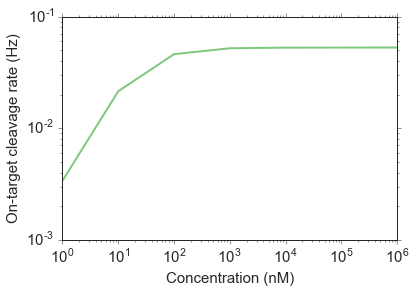

In [63]:
sns.set_palette('Accent');
plt.loglog(concentrations, OnTarget_clv_sweep, lw=2)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);
plt.xlabel('Concentration (nM)', fontsize=15)
plt.ylabel('On-target cleavage rate (Hz)', fontsize=15);

In [64]:
mm_positions = range(1,21)
TimeCLV = map(lambda x:Cas9.calc_Time(parameters=parameters,
                    mismatch_positions=[x],
                    model_ID=model_id,
                    rate_to_cleave=rate_to_cleave,
                    rel_conc=concentrations[-1]) , mm_positions )
TimeCLV = np.array(TimeCLV)
clv_Rates = (TimeCLV)**(-1)

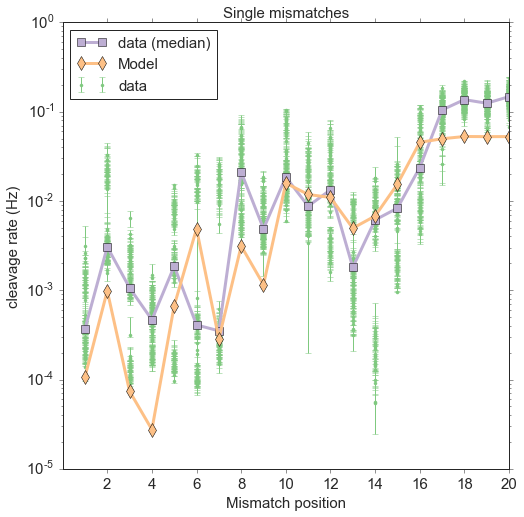

In [73]:
err = [data_1mm['cleavage_rate']-np.array(data_1mm['cleavage_rate_5th_pctl'])
       ,np.array(data_1mm['cleavage_rate_95th_pctl']-data_1mm['cleavage_rate'])]


plt.figure(figsize=(8,8))
plt.errorbar(x=data_1mm['MM_pos'], y=data_1mm['cleavage_rate'], yerr=err, fmt='.', label='data')
plt.semilogy(data_1mm_median['MM_pos'], data_1mm_median['cleavage_rate']/1.0,
        marker='s', markersize=8,lw=3,label='data (median)')
plt.semilogy(mm_positions,clv_Rates,marker='d',markersize=10,lw=3,label='Model')
plt.xticks(range(2,22,2), fontsize=15);
plt.yticks(fontsize=15);
plt.ylim([0,1.2]);
plt.xlabel('Mismatch position', fontsize=15)
plt.ylabel('cleavage rate (Hz)', fontsize=15);
plt.ylim([1e-5,1])
plt.legend(fontsize=15, loc = 'best');
plt.title('Single mismatches', fontsize=15)

fig_name = '1mm_clv.pdf'
plt.savefig(fig_name, format='pdf', bbox_inches='tight')

In [66]:
data_median_mm = data[data['Canonical']&(data['Length difference']==0)].copy()
data_median_mm['MM_pos'] = data_median_mm['Mutation ID'].apply(lambda x: [] if x=='' else map(lambda y: y.split(':')[1],x.split('|')))
data_median_mm['MM_posID'] = data_median_mm['MM_pos'].apply(lambda x: '|'.join(map(str,x)))
data_median_mm['Prediction'] = data_median_mm['MM_pos'].apply(lambda x:1.0/Cas9.calc_Time(parameters=parameters,
                    mismatch_positions=x,
                    model_ID=model_id,
                    rate_to_cleave=rate_to_cleave,
                    rel_conc=concentrations[-1]))
#data_median_mm = data_median_mm.groupby('MM_posID').median().reset_index()

In [67]:
data_median_mm_scatterplot = data_median_mm[['MM_posID', 'Mutation Count', 'Prediction', 'cleavage_rate']].copy()

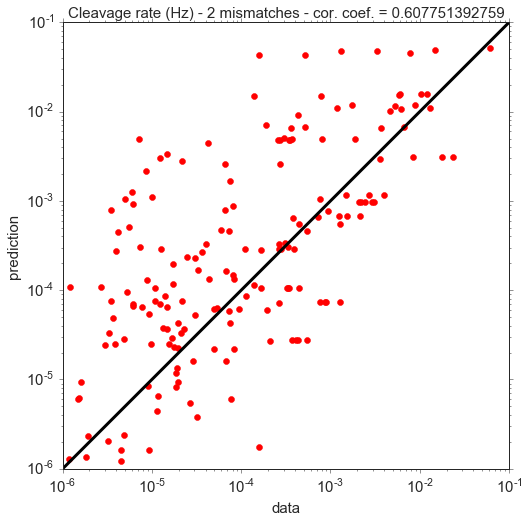

In [74]:
data_median_2mm_scatterplot = data_median_mm_scatterplot[data_median_mm_scatterplot['Mutation Count']==2]
cor = np.corrcoef(data_median_2mm_scatterplot['cleavage_rate'], data_median_2mm_scatterplot['Prediction'])[0,1]

plt.figure(figsize=(8,8))
plt.loglog(data_median_2mm_scatterplot['cleavage_rate'], data_median_2mm_scatterplot['Prediction'],'o', mfc='r', mec='r')
plt.plot([1e-6, 1e-1],[1e-6, 1e-1],'k-',lw=3)
plt.xlim([1e-6,0.1])
plt.ylim([1e-6,0.1])
plt.axes().set_aspect('equal')
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.xlabel('data', fontsize=15)
plt.ylabel('prediction', fontsize=15);
plt.title('Cleavage rate (Hz) - 2 mismatches - cor. coef. = '+str(cor), fontsize=15);

fig_name = '2mm_clv.pdf'
#plt.savefig(fig_name, format='pdf', bbox_inches='tight')

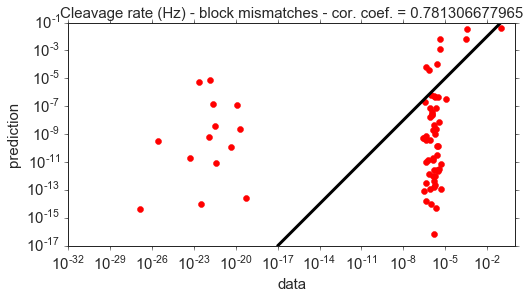

In [75]:
data_median_block_scatterplot = data_median_mm_scatterplot[data_median_mm_scatterplot['Mutation Count']>2]
cor = np.corrcoef(data_median_block_scatterplot['cleavage_rate'], data_median_block_scatterplot['Prediction'])[0,1]

plt.figure(figsize=(8,8))
plt.loglog(data_median_block_scatterplot['cleavage_rate'], data_median_block_scatterplot['Prediction'],'o', mfc='r', mec='r')
plt.plot([1e-17, 1e-1],[1e-17, 1e-1],'k-',lw=3)
#plt.xlim([1e-6,0.1])
#plt.ylim([1e-6,0.1])
plt.axes().set_aspect('equal')
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.xlabel('data', fontsize=15)
plt.ylabel('prediction', fontsize=15);
plt.title('Cleavage rate (Hz) - block mismatches - cor. coef. = '+str(cor), fontsize=15);

fig_name = 'blockmm_clv.pdf'
#plt.savefig(fig_name, format='pdf', bbox_inches='tight')